In [4]:
pip install plotly_express==0.4.0


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install Scrapy

  Using cached Scrapy-2.4.1-py2.py3-none-any.whl (239 kB)
  Using cached w3lib-1.22.0-py2.py3-none-any.whl (20 kB)
Processing /home/jovyan/.cache/pip/wheels/f2/36/1b/99fe6d339e1559e421556c69ad7bc8c869145e86a756c403f4/Twisted-20.3.0-cp38-cp38-linux_x86_64.whl
  Using cached parsel-1.6.0-py2.py3-none-any.whl (13 kB)
Processing /home/jovyan/.cache/pip/wheels/91/64/36/bd0d11306cb22a78c7f53d603c7eb74ebb6c211703bc40b686/Protego-0.1.16-py3-none-any.whl
  Using cached itemadapter-0.2.0-py3-none-any.whl (9.3 kB)
  Using cached zope.interface-5.2.0-cp38-cp38-manylinux2010_x86_64.whl (244 kB)
  Using cached cssselect-1.1.0-py2.py3-none-any.whl (16 kB)
  Using cached lxml-4.6.2-cp38-cp38-manylinux1_x86_64.whl (5.4 MB)
  Using cached service_identity-18.1.0-py2.py3-none-any.whl (11 kB)
  Using cached itemloaders-1.0.4-py3-none-any.whl (11 kB)
  Using cached queuelib-1.5.0-py2.py3-none-any.whl (13 kB)
Processing /home/jovyan/.cache/pip/wheels/d1/d7/61/11b5b370ee487d38b5408ecb7e0257db9107fa622412cbe2

In [6]:
pip install Boto3

     |████████████████████████████████| 130 kB 7.1 MB/s eta 0:00:01
  Using cached s3transfer-0.3.4-py2.py3-none-any.whl (69 kB)
     |████████████████████████████████| 7.2 MB 18.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install plotly==4.9.0
!pip install jupyterlab "ipywidgets>=7.5"
!jupyter labextension install jupyterlab-plotly@4.9.0
!jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.9.0
!jupyter labextension list

  Using cached plotly-4.9.0-py2.py3-none-any.whl (12.9 MB)
Processing /home/jovyan/.cache/pip/wheels/c4/a7/48/0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56/retrying-1.3.3-py3-none-any.whl
Building jupyterlab assets (build:prod:minimize)
Building jupyterlab assets (build:prod:minimize)
JupyterLab v2.2.8
Known labextensions:
   app dir: /opt/conda/share/jupyter/lab
        @bokeh/jupyter_bokeh v2.0.3  enabled  OK
        @jupyter-widgets/jupyterlab-manager v2.0.0  enabled  OK
        jupyter-matplotlib v0.7.4  enabled  OK
        jupyterlab-plotly v4.9.0  enabled  OK
        plotlywidget v4.9.0  enabled  OK


In [2]:
!jupyter lab build

[LabBuildApp] JupyterLab 2.2.8
[LabBuildApp] Building in /opt/conda/share/jupyter/lab
[LabBuildApp] Building jupyterlab assets (build:prod:minimize)


In [7]:
import os 
import logging
import scrapy
import requests
from scrapy.crawler import CrawlerProcess
import json
import pandas as pd
import plotly.express as px
import glob
import boto3

# Cities and creation of df

In [8]:
city_names= ["Mont Saint Michel",
"St Malo",
"Bayeux",
"Le Havre",
"Rouen",
"Paris",
"Amiens",
"Lille",
"Strasbourg",
"Chateau du Haut Koenigsbourg",
"Colmar",
"Eguisheim",
"Besancon",
"Dijon",
"Annecy",
"Grenoble",
"Lyon",
"Gorges du Verdon",
"Bormes les Mimosas"
]

In [9]:
df = pd.DataFrame(columns=['city_id' , 'name', 'latitude', 'longitude', 'main_weather', 'expected_rain', 'day_temperature'])
df

,city_id,name,latitude,longitude,main_weather,expected_rain,day_temperature


# Coordinates, weather info, convert df to csv

In [10]:
api_key = "f482d2b26c2e58bf480acbe962e74f18"

In [11]:
for i in range(len(city_names)):
    print("making request: {}".format(city_names[i]))
    
#get latitude and longitude of cities    
    
    par = {
        "city": city_names[i],
        "country": "France",
        "format": "json"
          }
    
    r = requests.get('https://nominatim.openstreetmap.org/search', params=par)
    res = r.json()
    
#fix lat and lon
    df.loc[i,'city_id'] = i
    df.loc[i,'name'] = city_names[i]
    df.loc[i, 'latitude'] = res[0]['lat']
    df.loc[i, 'longitude'] = res[0]['lon']
    
#get weather
    par = {
        "lat": df.loc[i, 'latitude'],
        "lon": df.loc[i, 'longitude'],
        "exclude": "current,minutely,hourly",
        "units": "metric",
        "appid": api_key,
           }
    
    r = requests.get('https://api.openweathermap.org/data/2.5/onecall', params=par)
    res = r.json()
    
    # Compute expected volume of rain
    expected_rain = 0
    print(res) 
    
    for d in res['daily']:
        if 'rain' in d.keys():
            expected_rain += d['pop']*d['rain']
            
    # Compute average day temperature
    temperatures = pd.Series([d['temp']['day'] for d in res['daily']])
    mean_temperature = temperatures.mean()

    # Extract most probable weather
    weathers = pd.Series([d['weather'][0]['main'] for d in res['daily']])
    main_weather = weathers.mode()[0]
    
    df.loc[i, 'main_weather'] = main_weather
    df.loc[i,'expected_rain'] = expected_rain
    df.loc[i,'day_temperature'] = mean_temperature


making request: Mont Saint Michel
{'lat': 48.6359, 'lon': -1.5126, 'timezone': 'Europe/Paris', 'timezone_offset': 3600, 'daily': [{'dt': 1611403200, 'sunrise': 1611387974, 'sunset': 1611420557, 'temp': {'day': 4.73, 'min': 2.21, 'max': 6.32, 'night': 2.21, 'eve': 3.07, 'morn': 3.04}, 'feels_like': {'day': -1.81, 'night': -0.16, 'eve': -1.14, 'morn': -0.58}, 'pressure': 995, 'humidity': 87, 'dew_point': 2.91, 'wind_speed': 7.14, 'wind_deg': 344, 'weather': [{'id': 502, 'main': 'Rain', 'description': 'heavy intensity rain', 'icon': '10d'}], 'clouds': 94, 'pop': 1, 'rain': 12.68, 'uvi': 0.77}, {'dt': 1611489600, 'sunrise': 1611474311, 'sunset': 1611507050, 'temp': {'day': 6.61, 'min': 1.44, 'max': 6.87, 'night': 4.42, 'eve': 5.04, 'morn': 1.8}, 'feels_like': {'day': -1.1, 'night': -3.8, 'eve': -3.95, 'morn': -4.1}, 'pressure': 998, 'humidity': 77, 'dew_point': 2.94, 'wind_speed': 8.83, 'wind_deg': 261, 'weather': [{'id': 500, 'main': 'Rain', 'description': 'light rain', 'icon': '10d'}], '

IndexError: list index out of range

In [12]:
df

,city_id,name,latitude,longitude,main_weather,expected_rain,day_temperature
0,0,Mont Saint Michel,48.6358559,-1.5126096,Rain,35.0379,8.52125
1,1,St Malo,48.6454528,-2.015418,Rain,32.6883,8.8525
2,2,Bayeux,49.2764624,-0.7024738,Rain,20.0091,7.89875
3,3,Le Havre,49.4938975,0.1079732,Rain,27.8346,7.785
4,4,Rouen,49.4404591,1.0939658,Rain,19.4916,7.52
5,5,Paris,48.8566969,2.3514616,Rain,16.6957,8.21875
6,6,Amiens,49.8941708,2.2956951,Rain,23.6011,7.2375
7,7,Lille,50.6365654,3.0635282,Rain,20.0471,6.6175
8,8,Strasbourg,48.584614,7.7507127,Rain,17.646,6.57625
9,9,Chateau du Haut Koenigsbourg,48.2495226,7.3454923,Rain,22.1153,3.67125


In [20]:
df.loc[:,'rank'] = df['expected_rain'].rank(method='min')
df.loc[:,'inverted_rank'] = df['expected_rain'].rank(method='min', ascending=False)
df = df.sort_values(by=['expected_rain', 'day_temperature'], ascending = [True, False]).reset_index(drop=True)
display(df)

,city_id,name,latitude,longitude,main_weather,expected_rain,day_temperature,rank,inverted_rank
0,17,Gorges du Verdon,0.000000,0.000000,0,0.0000,0.00000,1.0,18.0
1,16,Lyon,45.757814,4.832011,Rain,7.6248,7.73250,2.0,17.0
2,5,Paris,48.856697,2.351462,Rain,16.6957,8.21875,3.0,16.0
3,8,Strasbourg,48.584614,7.750713,Rain,17.6460,6.57625,4.0,15.0
4,4,Rouen,49.440459,1.093966,Rain,19.4916,7.52000,5.0,14.0
5,2,Bayeux,49.276462,-0.702474,Rain,20.0091,7.89875,6.0,13.0
6,7,Lille,50.636565,3.063528,Rain,20.0471,6.61750,7.0,12.0
7,15,Grenoble,45.187560,5.735782,Snow,21.0296,6.55000,8.0,11.0
8,9,Chateau du Haut Koenigsbourg,48.249523,7.345492,Rain,22.1153,3.67125,9.0,10.0
9,10,Colmar,48.077752,7.357964,Rain,22.4193,6.81625,10.0,9.0


In [21]:
print('Best places for a trip next week are : ')
print()

for i,row in df.loc[df['rank']==1,:].iterrows():
    print("{} -- Mostly {} with temperature {} °C".format(row['name'], row['main_weather'], row['day_temperature']))

Best places for a trip next week are : 

Gorges du Verdon -- Mostly 0 with temperature 0.0 °C


In [22]:
df = df.fillna(0)

In [23]:
df.loc[:,'latitude'] = df['latitude'].astype('float')
df.loc[:,'longitude'] = df['longitude'].astype('float')
df.loc[:,'expected_rain'] = df['expected_rain'].astype('float')
df.loc[:,'day_temperature'] = df['day_temperature'].astype('float')
df.loc[:,'rank'] = df['rank'].astype('int')
df.loc[:,'inverted_rank'] = df['inverted_rank'].astype('int')

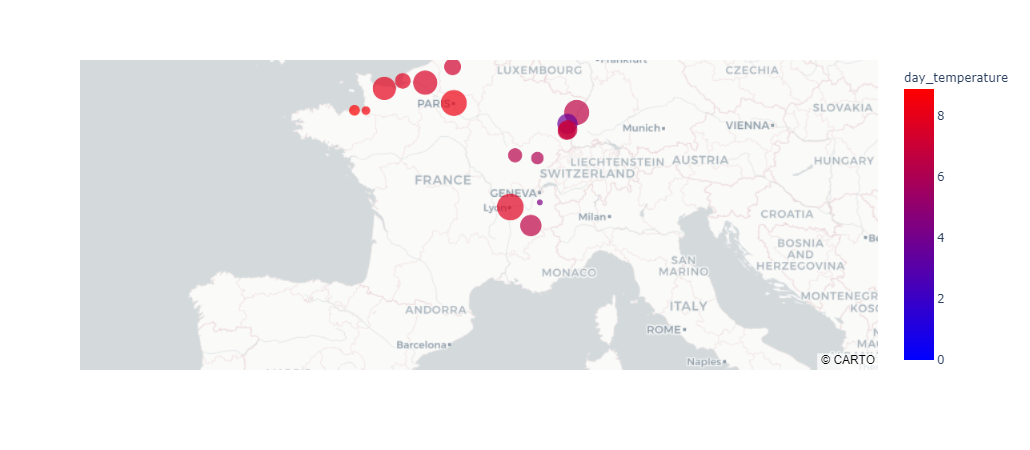

In [24]:
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", hover_name = 'name', zoom = 4,
                        hover_data = ['main_weather', 'expected_rain', 'day_temperature'], 
                        color = 'day_temperature', color_continuous_scale = 'Bluered', size = 'inverted_rank',
                        mapbox_style="carto-positron")
fig.show()

In [25]:
df.to_csv('destinations.csv', index=False)

# Scrapping Booking.com for hotel information

### La Rochelle

In [26]:
city = 'La Rochelle'

In [27]:
r = requests.get('https://www.booking.com/index.fr.html')
r

<Response [200]>

In [28]:
class BookingSpider(scrapy.Spider):
    name = "booking"

    start_urls = ['https://www.booking.com/index.fr.html']

    def parse(self, response):
        return scrapy.FormRequest.from_response(
            response,
            formdata={'ss': city},
            callback=self.after_search
        )

    def after_search(self, response):
        
        booking = response.css('.sr_item')

        for data in booking:
            yield {
                'name': data.css('.sr-hotel__name::text').get(),
                'url': 'https://www.booking.com' + data.css('.hotel_name_link').attrib["href"],
                'coords': data.css('.sr_card_address_line a').attrib["data-coords"],
                'score': data.css('.bui-review-score__badge::text').get(),
                'description': data.css('.hotel_desc::text').get()
                
            }
        
        
        try:
            next_page = response.css('a.paging-next').attrib["href"]
        except KeyError:
            logging.info('No next page. Terminating crawling process.')
        else:
            yield response.follow(next_page, callback=self.after_search)

In [29]:
filename = "hotels_" + city.replace(" ", "-") + ".json"


process = CrawlerProcess(settings = {
    'USER_AGENT': 'Chrome/84.0 (compatible; MSIE 7.0; Windows NT 5.1)',
    'LOG_LEVEL': logging.INFO,
    "FEEDS": {
        'res/' + filename: {"format": "json"},
    }
})

process.crawl(BookingSpider)
process.start()

2021-01-23 19:29:55 [scrapy.utils.log] INFO: Scrapy 2.4.1 started (bot: scrapybot)
2021-01-23 19:29:55 [scrapy.utils.log] INFO: Versions: lxml 4.6.2.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 20.3.0, Python 3.8.6 | packaged by conda-forge | (default, Oct  7 2020, 19:08:05) - [GCC 7.5.0], pyOpenSSL 19.1.0 (OpenSSL 1.1.1h  22 Sep 2020), cryptography 3.1.1, Platform Linux-4.19.112+-x86_64-with-glibc2.10
2021-01-23 19:29:55 [scrapy.crawler] INFO: Overridden settings:
{'LOG_LEVEL': 20,
 'USER_AGENT': 'Chrome/84.0 (compatible; MSIE 7.0; Windows NT 5.1)'}
2021-01-23 19:29:55 [scrapy.extensions.telnet] INFO: Telnet Password: aef51dbe523497c2
2021-01-23 19:29:55 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.feedexport.FeedExporter',
 'scrapy.extensions.logstats.LogStats']
2021-01-23 19:29:55 [scrapy.middleware] INFO: Ena

### Paris

In [30]:
city = 'Paris'

In [31]:
r = requests.get('https://www.booking.com/index.fr.html')
r

<Response [200]>

In [32]:
class BookingSpider(scrapy.Spider):
    name = "booking"

    start_urls = ['https://www.booking.com/index.fr.html']

    def parse(self, response):
        return scrapy.FormRequest.from_response(
            response,
            formdata={'ss': city},
            callback=self.after_search
        )

    def after_search(self, response):
        
        booking = response.css('.sr_item')

        for b in booking:
            yield {
                'name': b.css('.sr-hotel__name::text').get(),
                'url': 'https://www.booking.com' + b.css('.hotel_name_link').attrib["href"],
                'coords': b.css('.sr_card_address_line a').attrib["data-coords"],
                'score': b.css('.bui-review-score__badge::text').get(),
                'description': b.css('.hotel_desc::text').get()
                
            }
        
        
        try:
            next_page = response.css('a.paging-next').attrib["href"]
        except KeyError:
            logging.info('No next page. Terminating crawling process.')
        else:
            yield response.follow(next_page, callback=self.after_search)

In [33]:
filename = "hotels_" + city.replace(" ", "-") + ".json"


process = CrawlerProcess(settings = {
    'USER_AGENT': 'Chrome/84.0 (compatible; MSIE 7.0; Windows NT 5.1)',
    'LOG_LEVEL': logging.INFO,
    "FEEDS": {
        'res/' + filename: {"format": "json"},
    }
})

process.crawl(BookingSpider)
process.start()

2021-01-23 19:30:13 [scrapy.utils.log] INFO: Scrapy 2.4.1 started (bot: scrapybot)
2021-01-23 19:30:13 [scrapy.utils.log] INFO: Versions: lxml 4.6.2.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 20.3.0, Python 3.8.6 | packaged by conda-forge | (default, Oct  7 2020, 19:08:05) - [GCC 7.5.0], pyOpenSSL 19.1.0 (OpenSSL 1.1.1h  22 Sep 2020), cryptography 3.1.1, Platform Linux-4.19.112+-x86_64-with-glibc2.10
2021-01-23 19:30:13 [scrapy.crawler] INFO: Overridden settings:
{'LOG_LEVEL': 20,
 'USER_AGENT': 'Chrome/84.0 (compatible; MSIE 7.0; Windows NT 5.1)'}
2021-01-23 19:30:13 [scrapy.extensions.telnet] INFO: Telnet Password: b508f9eed7548582
2021-01-23 19:30:13 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.feedexport.FeedExporter',
 'scrapy.extensions.logstats.LogStats']
2021-01-23 19:30:13 [scrapy.middleware] INFO: Ena

ReactorNotRestartable: 

# Data lake with S3

In [37]:
cities = pd.read_csv('destinations.csv')
cities.head()

,city_id,name,latitude,longitude,main_weather,expected_rain,day_temperature,rank,inverted_rank
0,17,Gorges du Verdon,0.000000,0.000000,0,0.0000,0.00000,1,18
1,16,Lyon,45.757814,4.832011,Rain,7.6248,7.73250,2,17
2,5,Paris,48.856697,2.351462,Rain,16.6957,8.21875,3,16
3,8,Strasbourg,48.584614,7.750713,Rain,17.6460,6.57625,4,15
4,4,Rouen,49.440459,1.093966,Rain,19.4916,7.52000,5,14


In [38]:
hotel_files = glob.glob('res/_hotels_*.json')

hotels = pd.DataFrame(columns = ['city_id', 'city_name', 'hotel_id', 'name', 'url', 'latitude', 'longitude', 'score', 'description'])
hotels


,city_id,city_name,hotel_id,name,url,latitude,longitude,score,description


In [39]:
for f in hotel_files:
    city_name = f.split('_')[2].split('.')[0].replace("-"," ")

In [40]:
for f in hotel_files:
    city_id = cities.loc[cities['name'] == city_name,'city_id'].values[0]

In [41]:
hotel_files

['res/_hotels_Paris.json']

In [58]:
f1 = pd.read_json('res/hotels_Paris.json')
hotels=pd.DataFrame(f1)
hotels['name']=(hotels['name']).astype(str).replace('\n','',regex=True)
hotels['description']=(hotels['description']).astype(str).replace('\n','',regex=True)
hotels.head()

,name,url,coords,score,description
0,Elysées Union,https://www.booking.com\n/hotel/fr/elyseesunio...,"2.29176588356495,48.8683494219935","8,4","Occupant un bâtiment du XIXe siècle à Paris, l..."
1,Hyatt Regency Paris Etoile,https://www.booking.com\n/hotel/fr/hyatt-regen...,"2.28472741799624,48.8804098381377","8,4","Le Hyatt Regency Paris Etoile, connu autrefois..."
2,Hotel Lutetia,https://www.booking.com\n/hotel/fr/lutetia-par...,"2.327238,48.851244","8,9",L’Hotel Lutetia est un établissement de luxe e...
3,Pullman Paris Tour Eiffel,https://www.booking.com\n/hotel/fr/tour-eiffel...,"2.29256182909012,48.855604014139","8,3",L'hôtel 4 étoiles Pullman Paris Tour Eiffel es...
4,Hotel Prelude Opera,https://www.booking.com\n/hotel/fr/corona.fr.h...,"2.34349831938744,48.871934420399","9,0",L'Hotel Corona Opera se situe dans l'élégant 9...


In [59]:
split_data = hotels['coords'].str.split(',')
hotels.loc[:,'latitude'] = split_data.apply(lambda x: x[1])
hotels.loc[:,'longitude'] = split_data.apply(lambda x: x[0])
split_data




0      [2.29176588356495, 48.8683494219935]
1      [2.28472741799624, 48.8804098381377]
2                     [2.327238, 48.851244]
3       [2.29256182909012, 48.855604014139]
4       [2.34349831938744, 48.871934420399]
                       ...                 
995     [2.3464098572731, 48.8762389019165]
996                  [2.370153, 48.8748331]
997    [2.38599121570587, 48.8738147952617]
998                 [2.3791229, 48.8809536]
999    [2.28464267672121, 48.8458345949375]
Name: coords, Length: 1000, dtype: object

In [60]:
#hotels_all = hotels_all.append(hotels)

In [61]:
del hotels['coords']
hotels.head()

,name,url,score,description,latitude,longitude
0,Elysées Union,https://www.booking.com\n/hotel/fr/elyseesunio...,"8,4","Occupant un bâtiment du XIXe siècle à Paris, l...",48.8683494219935,2.29176588356495
1,Hyatt Regency Paris Etoile,https://www.booking.com\n/hotel/fr/hyatt-regen...,"8,4","Le Hyatt Regency Paris Etoile, connu autrefois...",48.8804098381377,2.28472741799624
2,Hotel Lutetia,https://www.booking.com\n/hotel/fr/lutetia-par...,"8,9",L’Hotel Lutetia est un établissement de luxe e...,48.851244,2.327238
3,Pullman Paris Tour Eiffel,https://www.booking.com\n/hotel/fr/tour-eiffel...,"8,3",L'hôtel 4 étoiles Pullman Paris Tour Eiffel es...,48.855604014139,2.29256182909012
4,Hotel Prelude Opera,https://www.booking.com\n/hotel/fr/corona.fr.h...,"9,0",L'Hotel Corona Opera se situe dans l'élégant 9...,48.871934420399,2.34349831938744


In [62]:
hotels.loc[:, 'city_name']='Paris'
hotels.loc[:, 'city_id'] = cities.loc[cities['name'] == city_name,'city_id'].values[0]
hotels.loc[:, 'latitude'] = hotels['latitude'].astype('float')
hotels.loc[:, 'longitude'] = hotels['longitude'].astype('float')
hotels.loc[:, 'score'] = hotels['score'].str.replace(',','.').astype('float')

In [63]:
hotels.head()

,name,url,score,description,latitude,longitude,city_name,city_id
0,Elysées Union,https://www.booking.com\n/hotel/fr/elyseesunio...,8.4,"Occupant un bâtiment du XIXe siècle à Paris, l...",48.868349,2.291766,Paris,5
1,Hyatt Regency Paris Etoile,https://www.booking.com\n/hotel/fr/hyatt-regen...,8.4,"Le Hyatt Regency Paris Etoile, connu autrefois...",48.880410,2.284727,Paris,5
2,Hotel Lutetia,https://www.booking.com\n/hotel/fr/lutetia-par...,8.9,L’Hotel Lutetia est un établissement de luxe e...,48.851244,2.327238,Paris,5
3,Pullman Paris Tour Eiffel,https://www.booking.com\n/hotel/fr/tour-eiffel...,8.3,L'hôtel 4 étoiles Pullman Paris Tour Eiffel es...,48.855604,2.292562,Paris,5
4,Hotel Prelude Opera,https://www.booking.com\n/hotel/fr/corona.fr.h...,9.0,L'Hotel Corona Opera se situe dans l'élégant 9...,48.871934,2.343498,Paris,5


In [64]:
hotels.to_csv('res/0_hotels.csv', index=False)

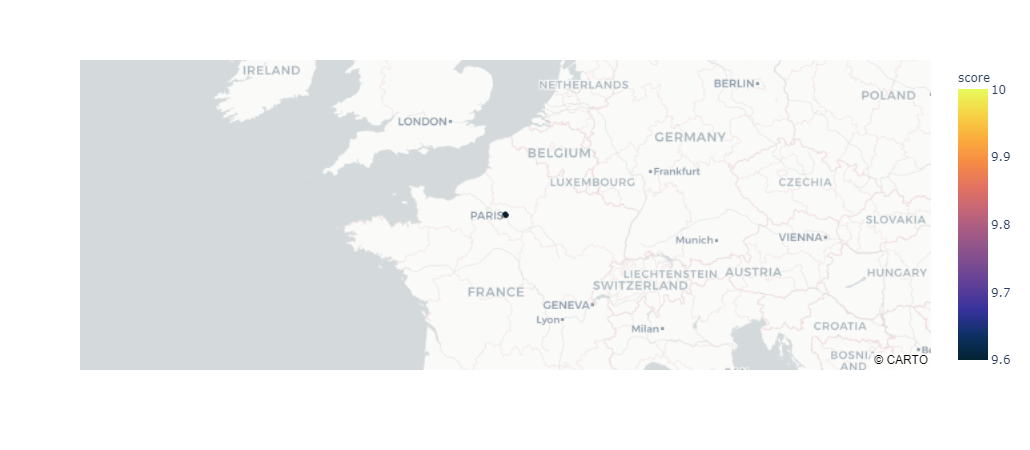

In [67]:

hotels_with_score = hotels.loc[hotels['score']>9.5,:]

fig = px.scatter_mapbox(hotels_with_score, lat="latitude", lon="longitude", hover_name = 'name', zoom = 4,
                        hover_data = ['description'],
                        color = 'score', color_continuous_scale = 'thermal',
                        mapbox_style="carto-positron")
fig.show()